# Reinforcement learning  model of spatial navigation
#### Lukas Dippold, Evert de Man

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geometry as geo
import matplotlib.colors as col
import matplotlib as mpl

In [2]:
#creates a random startpoint within a circle with radius r around the center
def start_point(center, r):

    # center of the circle (x, y)
    circle_x = center[0]
    circle_y = center[1]

    # random angle
    alpha = 2 * np.pi * np.random.random()
    # random radius
    rad = r * np.random.random()
    # calculating coordinates
    x = rad * np.cos(alpha) + circle_x
    y = rad * np.sin(alpha) + circle_y
    return np.array([x,y])

#needs startpoint and a, the direction the rat is going in rad
def step(start, a):
    l = np.random.normal(3,1.5) #length of a step, mean = 3, std.dev = 1.5

    x = start[0] + l*np.cos(a) 
    y = start[1] + l*np.sin(a)
    return np.array([x,y])


#calculates activity of an input neuron
def activity(delta,sigma,neuron,pos):
    dx = (neuron[0]-pos[0])**2
    dy = (neuron[1]-pos[1])**2
    return delta*np.exp(-1*(dx+dy)/(2*sigma**2))

#calculates the place field centers
def calculate_pfc():
    #center coordinates of place field centers
    x1 = np.arange(2.5,10,5)
    y1 = np.arange(2.5,50,5)
    x2 = np.arange(-47.5,60,5)
    y2 = np.arange(52.5,60,5)

    centers = []

    for y in y1:
        for x in x1:
            centers.append((x,y))
    for y in y2:
        for x in x2:
            centers.append((x,y))
    #coordinates of the place field centers of input neurons
    pfc = np.array(centers)
    return pfc

In [8]:
class t_maze:
        
    def __init__(self, n_a, lr=0.001, la=0.95):
        #neurons: pfc = place field centers (input layer), n = number of actions (output layer)
        self.n = n_a
        self.pfc = calculate_pfc()
        
        
        #geometry of the maze
        self.edges = [(0,0),(10,0),(10,50),(60,50),(60,60),(-50,60),(-50,50),(0,50),(0,0)]
        self.pickup = [(40,60),(40,50)]
        self.target = [(-30,60),(-30,50)]
        
        #start position of rat and neuron population 0 as active
        self.rat = start_point((5,5),5)
        self.alpha = 0 
        
        ################ this is new too #######################
        self.alpha_old = 0
        
        #learning variables
        self.w0 = np.random.random([self.n,self.pfc.shape[0]])
        self.w1 = np.random.random([self.n,self.pfc.shape[0]])
        #self.e_trace = np.zeros([self.n,self.pfc.shape[0]])
        self.e_trace0 = np.zeros([self.n,self.pfc.shape[0]])
        self.e_trace1 = np.zeros([self.n,self.pfc.shape[0]])

        
        self.eps = 0.999          #for epsilon-greedy policy
        self.learning_rate = lr  #for weight update
        self.gamma = 0.95         #reward discount factor
        self.lamda = la        #decay rate of eligibility trace
        self.q = np.random.random(4)
        self.q_next = np.random.random(4)
        self.a, self.action = self.policy(self.rat)
        self.a_next = 0.
        
    def reset(self):
        self.e_trace0 = np.zeros([self.n,self.pfc.shape[0]])
        self.e_trace1 = np.zeros([self.n,self.pfc.shape[0]])
        self.q = np.random.random(4)
        self.q_next = np.random.random(4)
    
    def new_pos(self):
        reward = 0
        goal = 0
        #choose direction
        a = self.a
        
        #go step in direction, end(=s') is the goal of the step in direction a
        end = step(self.rat, a)
        
        #check if step is possible or if rat hits a wall
        intersect = []
        for i,p in enumerate(self.edges[:-1]):
                      
            isp = geo.calculateIntersectPoint(self.rat,end,p,self.edges[i+1])
            ip = (isp,i)
            #append to intersect list all intersections with borders
            if isp is not None:
                intersect.append(ip)
         
        if len(intersect) != 0 :
            #rat hit the wall ->QUEST: what if it would hit 2 walls...
            reward = -1
            end = np.array(intersect[0][0])
            wall = intersect[0][1]
            
            #correct position that rat is not sitting on wall
            s = 1e-1
            if wall in [0,2,6]:
                end[1] += s
            elif wall in [1,3]:
                end[0] -= s
            elif wall in [5,7]:
                end[0] += s
            elif wall in [4]: 
                end[1] -= s
            else: 
                print ('error in position correction')
       
        if geo.calculateIntersectPoint(self.rat,end, self.pickup[0],self.pickup[1]) is not None:
            #pickup region is reached
            self.alpha = 1
            
        if((geo.calculateIntersectPoint(self.rat,end, self.target[0],self.target[1]) is not None)&(self.alpha==1)):
            #target area is reached and pickup area was reached before
            reward += 20
            goal = 1
        
        #choose a' from s' using policy
        self.a_next,action_next = self.policy(end)
        #calculate the update factor
        delta_t = reward + self.gamma * self.q_next - self.q
        
        #calculate eligibility trace, ???what is delta_a,at???
        delta_a_at = 1
        act = np.array([activity(1,5,c,self.rat) for c in self.pfc]) 
        #self.e_trace[self.action,:] = self.gamma * self.lamda * self.e_trace[self.action,:] + act * delta_a_at
        
        ###################################################################################
        ############################### your previous solution ############################
        """
        #update the weights
        if self.alpha == 0:
            self.e_trace0[self.action,:] = self.gamma * self.lamda * self.e_trace0[self.action,:] + act * delta_a_at
            self.w0[self.action,:] = self.w0[self.action,:] + self.learning_rate * delta_t * self.e_trace0[self.action,:]
        else:
            self.e_trace1[self.action,:] = self.gamma * self.lamda * self.e_trace1[self.action,:] + act * delta_a_at
            self.w1[self.action,:] = self.w1[self.action,:] + self.learning_rate * delta_t * self.e_trace1[self.action,:]
        """
        ###################################################################################
        
        
#         ###################################################################################
#         ############################## the correct implementation #########################
#         #update the weights
#         self.e_trace0 = self.gamma * self.lamda * self.e_trace0
#         self.e_trace1 = self.gamma * self.lamda * self.e_trace1
        
#         if self.alpha_old == 0:        
#             self.e_trace0[self.action,:] += act
#         else:
#             self.e_trace1[self.action,:] += act
        
#         self.w0 = self.w0 + self.learning_rate * delta_t * self.e_trace0
#         self.w1 = self.w1 + self.learning_rate * delta_t * self.e_trace1
#         ###################################################################################
          
        #new version 
        if self.alpha_old == 0: 
            self.e_trace0 = self.gamma * self.lamda * self.e_trace0
            self.e_trace0[self.action,:] += act
            self.w0 = self.w0 + self.learning_rate * delta_t * self.e_trace0
        
        else:
            self.e_trace1 = self.gamma * self.lamda * self.e_trace1
            self.e_trace1[self.action,:] += act
            self.w1 = self.w1 + self.learning_rate * delta_t * self.e_trace1
        
        #update current state and action
        self.a = self.a_next
        self.action = action_next
        self.rat = end
        self.alpha_old = self.alpha
        
        #if goal is reached reset start point and activate popultion 0 
        if goal == 1:
            self.rat = start_point((5,5),5)
            self.alpha = 0
            
            ############### this is new too ###############
            self.alpha_old = 0
            
        #end is next state
        return goal,end
    
    #returns action a in state s 
    def policy(self, state):
        self.q = self.q_next
        #activity of neurons depending on the state
        act = np.array([activity(1,5,c,state) for c in self.pfc]) 
        #kronecker symbol not needed in activity: decision which population active within weights
        if self.alpha == 0:
            q_val = self.w0.dot(act)
        else:
            q_val = self.w1.dot(act)
        
        #choose direction
        if np.random.uniform(0,1) <= (1-self.eps):
            #choose maximum Q value
            a_star = np.argmax(q_val)
        else:
            #choose random Q value
            a_star = np.random.choice(np.arange(0,self.n))
        
        self.q_next = q_val[a_star]
        a = (a_star+1)*2*np.pi/self.n
        #return direction in rad
        return a,a_star
    
    #do training trials
    def training(self,trials,mode=1):
        trial_steps = []
        
        #choosing the course of exploration/ exploitation
        if mode == 1:
            ##linearly decreasing epsilons
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]
        elif mode == 2:
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]**2
        elif mode == 3:
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]**4
        elif mode == 4:
            epsilons = -np.linspace(0.1,self.eps,trials)**2 + 0.999
        elif mode == 5:
            epsilons = -np.linspace(0.1,self.eps,trials)**4 + 0.999
        else:
            print("no valid training mode")
            
            
        for ep in epsilons:
            self.eps = ep
            g = 0
            count_steps = 0
            while(g==0):
                g,p = self.new_pos()    
                count_steps+=1
            trial_steps.append(count_steps)
            #self.reset()
        return trial_steps
    

### 1: Escape latency for 10 rats

In [11]:
# Initialization
m = t_maze(4, 0.01, 0.95)

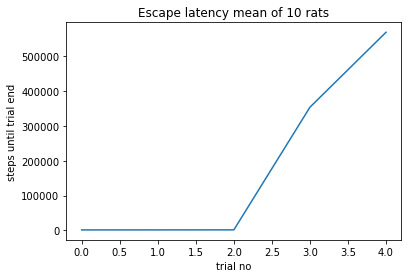

In [12]:
# Simulation of 10 rats
no_rats = 1
no_trials = 5

step_trial = np.zeros([no_rats, no_trials])

for i in range(no_rats):
    step_trial[i,:] = m.training(no_trials)
    
plt.plot(step_trial.mean(axis = 0))
plt.ylabel("steps until trial end")
plt.xlabel("trial no")
plt.title("Escape latency mean of 10 rats")
plt.show()

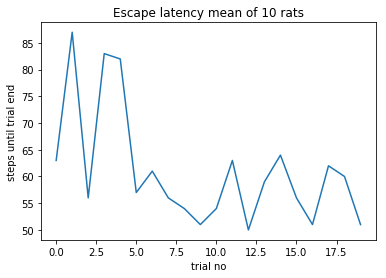

### 2: Path of rat through the maze

steps:  5168


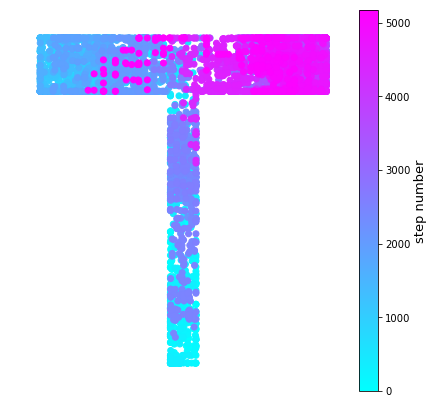

In [5]:
# Let rat explore

m = t_maze(4)
i = 0
g = 0
xPos = []
yPos = []
while(g==0):
    g,p = m.new_pos()    
    xPos.append(p[0])
    yPos.append(p[1])
    i+=1
print ('steps: ',i)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=i)

fig = plt.figure(figsize=(7,7))
plt.xlim(-55,65)
plt.ylim(-5,65)
plt.axis('off')

plt.scatter(xPos,yPos, c= range(i),cmap=cmap,norm=norm) 
cbar = plt.colorbar()
cbar.ax.set_ylabel('step number',size = '13')
plt.show()

In [ ]:
# Simulate the steps of a rat after learning how to do the maze 

m.training(10)

i = 0
g = 0
xPos = []
yPos = []
while(g==0):
    g,p = m.new_pos()    
    xPos.append(p[0])
    yPos.append(p[1])
    i+=1
print ('steps: ',i)

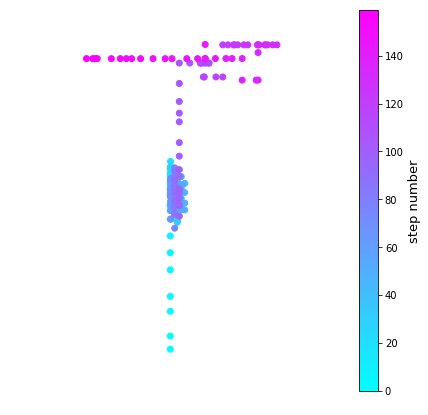

In [6]:
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=i)

fig = plt.figure(figsize=(7,7))
plt.xlim(-55,65)
plt.ylim(-5,65)
plt.axis('off')

plt.scatter(xPos, yPos, c=range(i), cmap=cmap, norm=norm) 
cbar = plt.colorbar()
cbar.ax.set_ylabel('step number', size = '13')
plt.show()

### 3: Comparing Learing Curves for different decay and learning rates 
We observe that high lambda values produce a much better learing curve. The eligibility trace is the memory of the past and adjusting how much the weights should be updated according to their position. The decay rate $\lambda$ is regarding the agents memory. A high $\lambda$ means that the agent will only slowly forget the past actions and states whereas a low $\lambda$ means the agent is really forgetful.


In [46]:
#test different learning rates and lambdas 
lrates = [0.001,0.0005,0.0001]
lambdas = [0.1,0.5,0.7,0.85,0.9,0.95]
steps = []

for lr in lrates:
    for la in lambdas: 
        m = t_maze(4,lr,la)
        steps.append(m.training(50))

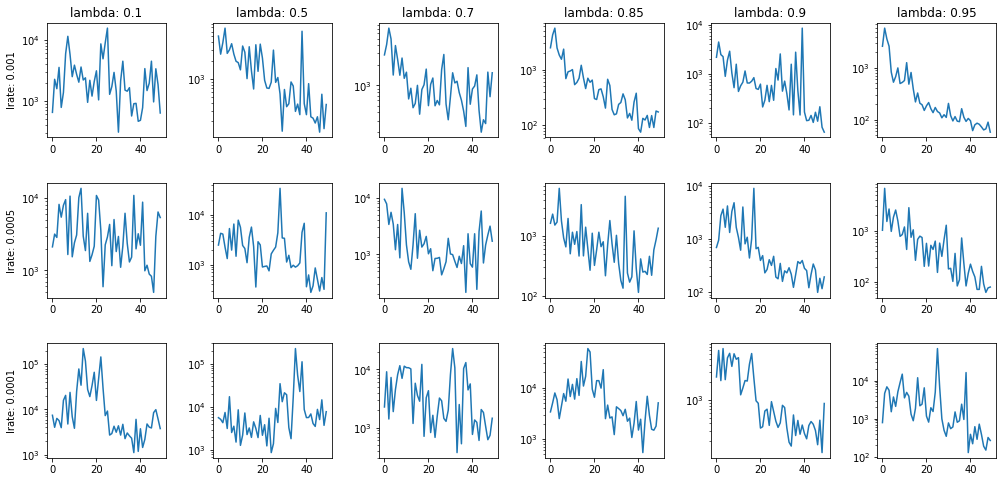

In [47]:
fig, axs = plt.subplots(3,6, figsize=(17, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0.4)

axs = axs.ravel()

for i,s in enumerate(steps):
    axs[i].plot(s)
    axs[i].set_yscale('log')
    
axs[0].set_ylabel('lrate: 0.001')
axs[6].set_ylabel('lrate: 0.0005')
axs[12].set_ylabel('lrate: 0.0001')

axs[0].set_title('lambda: 0.1')
axs[1].set_title('lambda: 0.5')
axs[2].set_title('lambda: 0.7')
axs[3].set_title('lambda: 0.85')
axs[4].set_title('lambda: 0.9')
axs[5].set_title('lambda: 0.95')

plt.show()

### 4: Varying the time course of exploration/ exploitation parameter $\epsilon$
the following graph shows the 5 different scenarios of the time course of the exploration/ exploitation parameter.
the linear decrease (1) is the standard case in our model. in this exercise we look at different options to handle
the exploration/ exploitation dilemma. (2) & (3) are quicker switiching to exploitation whereas (4) & (5) are 
longer exploring the enviroment. The learing curves of the different options show, that all are learing the task. (4) & (5) are producing a nicer and smoother learing curve. Outlier trials with a lot of steps are rare. (2) & (3) are quicker converging towards >10² steps but we observe more outlier trials. For detailed results more testing is necessary like that what we did in bullet point one. But because of the computational effort we cannot provide this for every single task. 

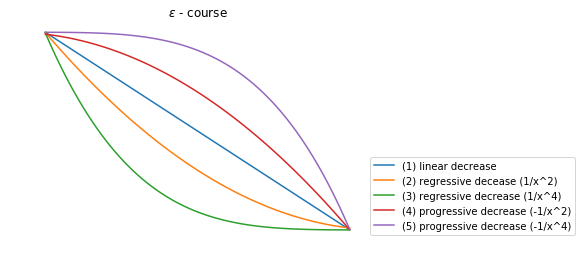

In [6]:
#linear vs. progressive decrease 
plt.plot(np.linspace(0.001,0.999,100)[::-1] ,label='(1) linear decrease')
plt.plot(np.linspace(0.1,0.999,100)[::-1]**2,label = '(2) regressive decease (1/x^2)')
plt.plot(np.linspace(0.1,0.999,100)[::-1]**4,label = '(3) regressive decrease (1/x^4)')
plt.plot(-np.linspace(0.1,0.999,100)**2 + 0.999,label = '(4) progressive decrease (-1/x^2)')
plt.plot(-np.linspace(0.1,0.999,100)**4 + 0.999,label = '(5) progressive decrease (-1/x^4)')

plt.axis('off')
plt.title('$\epsilon$ - course')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')
plt.show()

In [5]:
steps4 = []
for i in range(1,6):
    m = t_maze(4)
    steps4.append(m.training(50, mode=i))

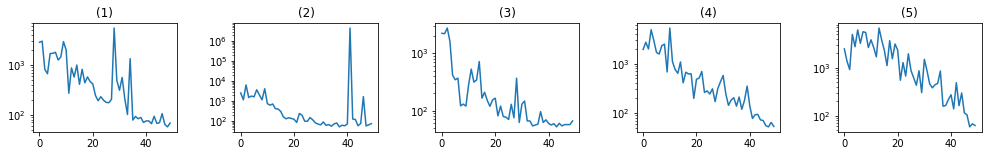

In [11]:
fig, axs = plt.subplots(1,5, figsize=(17, 2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0.4)

axs = axs.ravel()

for i,s in enumerate(steps4):
    axs[i].plot(s)
    axs[i].set_yscale('log')
    
axs[0].set_title('(1)')
axs[1].set_title('(2)')
axs[2].set_title('(3)')
axs[3].set_title('(4)')
axs[4].set_title('(5)')

plt.show()

### 5: Vary number of action cells
In this task we increase the number of possible directions the rat can do. In the standard case there are 4 different actions: up, right, down, left. When the number of actions is increasing, the directions are changing depending on the equation 360°/[# of actions]. We compare the results of 50 Training trials with 4,5,6,7 or 8 possible actions. More possibilities lead to more steps when the rat is untrained. That makes sense for our task because only up and right are good actions for the task. In another enviroment this could be different. But when it comes to training, there are not big differences. as the 5 training graphs show, the learing curves look more or less similar. 

steps:  3147


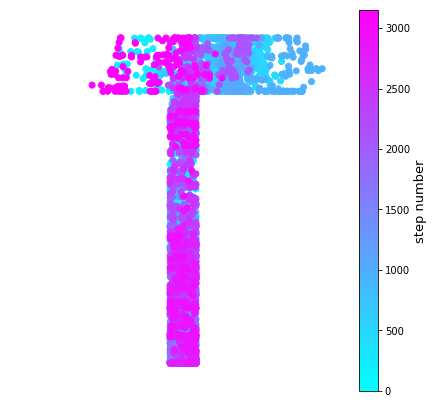

In [8]:
m = t_maze(6)

i = 0
g = 0
xPos = []
yPos = []
while(g==0):
    g,p = m.new_pos()    
    xPos.append(p[0])
    yPos.append(p[1])
    i+=1
print ('steps: ',i)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=i)

fig = plt.figure(figsize=(7,7))
plt.xlim(-55,65)
plt.ylim(-5,65)
plt.axis('off')


plt.scatter(xPos,yPos, c= range(i),cmap=cmap,norm=norm) 
cbar = plt.colorbar()
cbar.ax.set_ylabel('step number',size = '13')
plt.show()

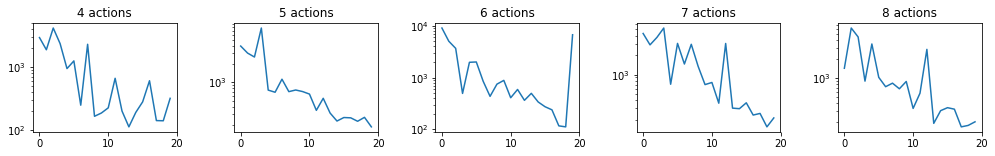

In [5]:
steps5 = []
for i in range(4,9):
    m = t_maze(i)
    steps5.append(m.training(20))

#plotting:
fig, axs = plt.subplots(1,5, figsize=(17, 2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0.4)
axs = axs.ravel()

for i,s in enumerate(steps5):
    axs[i].plot(s)
    axs[i].set_yscale('log')
    
axs[0].set_title('4 actions')
axs[1].set_title('5 actions')
axs[2].set_title('6 actions')
axs[3].set_title('7 actions')
axs[4].set_title('8 actions')

plt.show()

### Last additional point
In the end we will have a look at a mistake we did within the process of building our model. It is a common observation in machine learing that you build a model and the model is producing nice results although the algorithm was implemented wronly. In our case we used one eligibility matrix instead of two that would be corresponding to the 2 population of neurons. The first population is guiding the rat to the pickup area and the second population is learning the way from the pickup area to the goal. It does not make sense to mix this up, but as the graph below shows, it is also working and the rat is learning the task.

In [4]:
#here we show our results with one eligibility trace matrix...
class t_maze_1etrace:
        
    def __init__(self, n_a, lr=0.001, la=0.95):
        #neurons: pfc = place field centers (input layer), n = number of actions (output layer)
        self.n = n_a
        self.pfc = calculate_pfc()
        
        
        #geometry of the maze
        self.edges = [(0,0),(10,0),(10,50),(60,50),(60,60),(-50,60),(-50,50),(0,50),(0,0)]
        self.pickup = [(40,60),(40,50)]
        self.target = [(-30,60),(-30,50)]
        
        #start position of rat and neuron population 0 as active
        self.rat = start_point((5,5),5)
        self.alpha = 0            
        
        #learning variables
        self.w0 = np.random.random([self.n,self.pfc.shape[0]])
        self.w1 = np.random.random([self.n,self.pfc.shape[0]])
        self.e_trace = np.zeros([self.n,self.pfc.shape[0]])
        #self.e_trace0 = np.zeros([self.n,self.pfc.shape[0]])
        #self.e_trace1 = np.zeros([self.n,self.pfc.shape[0]])

        
        self.eps = 0.999          #for epsilon-greedy policy
        self.learning_rate = lr  #for weight update
        self.gamma = 0.95         #reward discount factor
        self.lamda = la        #decay rate of eligibility trace
        self.q = np.random.random(4)
        self.q_next = np.random.random(4)
        self.a, self.action = self.policy(self.rat)
        self.a_next = 0.
    
    def new_pos(self):
        reward = 0
        goal = 0
        #choose direction
        a = self.a
        
        #go step in direction, end(=s') is the goal of the step in direction a
        end = step(self.rat, a)
        
        #check if step is possible or if rat hits a wall
        intersect = []
        for i,p in enumerate(self.edges[:-1]):
                      
            isp = geo.calculateIntersectPoint(self.rat,end,p,self.edges[i+1])
            ip = (isp,i)
            #append to intersect list all intersections with borders
            if isp is not None:
                intersect.append(ip)
         
        if len(intersect) != 0 :
            #rat hit the wall ->QUEST: what if it would hit 2 walls...
            reward = -1
            end = np.array(intersect[0][0])
            wall = intersect[0][1]
            
            #correct position that rat is not sitting on wall
            s = 1e-1
            if wall in [0,2,6]:
                end[1] += s
            elif wall in [1,3]:
                end[0] -= s
            elif wall in [5,7]:
                end[0] += s
            elif wall in [4]: 
                end[1] -= s
            else: 
                print ('error in position correction')
       
        if geo.calculateIntersectPoint(self.rat,end, self.pickup[0],self.pickup[1]) is not None:
            #pickup region is reached
            self.alpha = 1
            
        if((geo.calculateIntersectPoint(self.rat,end, self.target[0],self.target[1]) is not None)&(self.alpha==1)):
            #target area is reached and pickup area was reached before
            reward += 20
            goal = 1
        
        #choose a' from s' using policy
        self.a_next,action_next = self.policy(end)
        #calculate the update factor
        delta_t = reward + self.gamma * self.q_next - self.q
        
        #calculate eligibility trace, ???what is delta_a,at???
        delta_a_at = 1
        act = np.array([activity(1,5,c,self.rat) for c in self.pfc]) 
        self.e_trace[self.action,:] = self.gamma * self.lamda * self.e_trace[self.action,:] + act * delta_a_at
        
        #update the weights
        if self.alpha == 0:
            #self.e_trace0[self.action,:] = self.gamma * self.lamda * self.e_trace0[self.action,:] + act * delta_a_at
            self.w0[self.action,:] = self.w0[self.action,:] + self.learning_rate * delta_t * self.e_trace[self.action,:]

        else:
            #self.e_trace1[self.action,:] = self.gamma * self.lamda * self.e_trace1[self.action,:] + act * delta_a_at
            self.w1[self.action,:] = self.w1[self.action,:] + self.learning_rate * delta_t * self.e_trace[self.action,:]

        #update current state and action
        self.a = self.a_next
        self.action = action_next
        self.rat = end
        
        #if goal is reached reset start point and activate popultion 0 
        if goal == 1:
            self.rat = start_point((5,5),5)
            self.alpha = 0 
            
        #end is next state
        return goal,end
    
    #returns action a in state s 
    def policy (self,state):
        self.q = self.q_next
        #activity of neurons depending on the state
        act = np.array([activity(1,5,c,state) for c in self.pfc]) 
        #kronecker symbol not needed in activity: decision which population active within weights
        if self.alpha == 0:
            q_val = self.w0.dot(act)
        else:
            q_val = self.w1.dot(act)
        
        #choose direction
        if np.random.uniform(0,1) <= (1-self.eps):
            #choose maximum Q value
            a_star = np.argmax(q_val)
        else:
            #choose random Q value
            a_star = np.random.choice(np.arange(0,self.n))
        
        self.q_next = q_val[a_star]
        a = (a_star+1)*2*np.pi/self.n
        #return direction in rad
        return a,a_star
    
    #do training trials
    def training(self,trials,mode=1):
        trial_steps = []
        
        #choosing the course of exploration/ exploitation
        if mode == 1:
            ##linearly decreasing epsilons
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]
        elif mode == 2:
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]**2
        elif mode == 3:
            epsilons = np.linspace(0.1,self.eps,trials)[::-1]**4
        elif mode == 4:
            epsilons = -np.linspace(0.1,self.eps,trials)**2 + 0.999
        elif mode == 5:
            epsilons = -np.linspace(0.1,self.eps,trials)**4 + 0.999
        else:
            print("no valid training mode")
            
            
        for ep in epsilons:
            self.eps = ep
            g = 0
            count_steps = 0
            while(g==0):
                g,p = self.new_pos()    
                count_steps+=1
            trial_steps.append(count_steps)
        return trial_steps
    

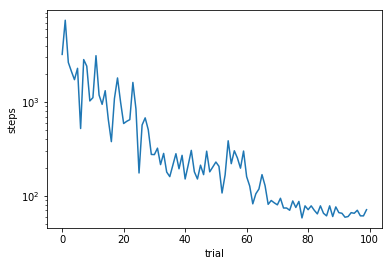

In [5]:
# train a t-maze with one eligibility trace matrix
m = t_maze_1etrace(4)

step_trial = m.training(100)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(step_trial)
ax.set_yscale('log')
ax.set_xlabel('trial')
ax.set_ylabel('steps')
plt.show()